# 03 - Vertex AI Custom Model - scikit-learn - in Notebook

Where a model gets trained is where it consumes computing resources.  With Vertex AI, you have choices for configuring the computing resources available at training.  This notebook is an example of an execution environment.  When it was set up there were choices for machine type and accelerators (GPUs).  

This notebook shows training a model directly within the runtime of the notebook environment.  Then the model is saved and moved to GCS for deployment to a Vertex AI > Endpoint for online predictions.  The model training is done with [scikit-learn](https://scikit-learn.org/stable/), and is designed to show a standard approach to logistic regression.  The training data batches are read from BigQuery using the [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html).

The other notebooks in this series (`04a-04i`) show how to move the training into a managed compute environment using Vertex AI > Training.  The first step to being able to use a training job is converting the code in this notebook into a training script.  This processs is covered in:
- [03 - Vertex AI Custom Model - scikit-learn - Notebook to Script.ipynb](./03%20-%20Vertex%20AI%20Custom%20Model%20-%20scikit-learn%20-%20Notebook%20to%20Script.ipynb)
- [03 - Vertex AI Custom Model - scikit-learn - Notebook to Hyperparameter Tuning Script.ipynb](./03%20-%20Vertex%20AI%20Custom%20Model%20-%scikit-learn%20-%20Notebook%20to%20Hyperparameter%20Tuning%20Script.ipynb) (WIP)

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [sklearn](https://scikit-learn.org/stable/)
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
- Pre-built Containers for Vertex AI
    - [Training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
    - [Prediction & Explaination](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../img/slides/05_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../img/slides/05_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'demos-vertex-ai'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '03'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-23:latest'
TRAINING_IMAGE = 'us-docker.pkg.dev/vertex-ai/training/sklearn-cpu.0-23:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id-splits' #add more variables to the string with '-' delimiters


packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import storage

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics

import pickle
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import json

from datetime import datetime
import os

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project=PROJECT_ID)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
DIR = f"temp/{EXPERIMENT}"
BLOB = f"{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model/model.pkl"

experiment tracking:

In [6]:
FRAMEWORK = 'sklearn'
TASK = 'classification'
MODEL_TYPE = 'logistic-regression'
EXPERIMENT_NAME = f'experiment-{SERIES}-{EXPERIMENT}-{FRAMEWORK}-{TASK}-{MODEL_TYPE}'
RUN_NAME = f'run-{TIMESTAMP}'

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Setup Vertex AI Experiments

The code in this section initializes the experiment and starts a run that represents this notebook.  Throughout the notebook sections for model training and evaluation information will be logged to the experiment using:
- [.log_params](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_params)
- [.log_metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_metrics)
- [.log_time_series_metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_time_series_metrics)

Initialize the Experiment:

In [8]:
aiplatform.init(experiment = EXPERIMENT_NAME)

Creating Tensorboard
Create Tensorboard backing LRO: projects/746038361521/locations/us-central1/tensorboards/2949624659462586368/operations/9161736610457321472
Tensorboard created. Resource name: projects/746038361521/locations/us-central1/tensorboards/2949624659462586368
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/746038361521/locations/us-central1/tensorboards/2949624659462586368')


Create an experiment run:

In [9]:
expRun = aiplatform.ExperimentRun.create(run_name = RUN_NAME, experiment = EXPERIMENT_NAME)

Associating projects/746038361521/locations/us-central1/metadataStores/default/contexts/experiment-03-03-sklearn-classification-logistic-regression-run-20250121203058 to Experiment: experiment-03-03-sklearn-classification-logistic-regression


Log parameters to the experiment run:

In [10]:
expRun.log_params({'experiment': EXPERIMENT, 'series': SERIES, 'project_id': PROJECT_ID})

---
## Training Data
In this exercise the data source is a table in Google BigQuery.  While it is possible to bring the entire table into the local notebook as a Pandas dataframe, it is not a scalable solution for very large training tables.

### Data Schema
Using BigQueries Information_Schema is an easy way to quickly retrieve the column information about our training data.  In this case we need the column names and data types to setup the data reading and the model inputs.  This section retrieves the column information for the training table source.

In [11]:
query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS` WHERE TABLE_NAME = '{BQ_TABLE}'"
schema = bq.query(query).to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default,rounding_mode
0,demos-vertex-ai,fraud,fraud_prepped,Time,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
1,demos-vertex-ai,fraud,fraud_prepped,V1,2,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
2,demos-vertex-ai,fraud,fraud_prepped,V2,3,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
3,demos-vertex-ai,fraud,fraud_prepped,V3,4,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
4,demos-vertex-ai,fraud,fraud_prepped,V4,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
5,demos-vertex-ai,fraud,fraud_prepped,V5,6,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
6,demos-vertex-ai,fraud,fraud_prepped,V6,7,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
7,demos-vertex-ai,fraud,fraud_prepped,V7,8,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
8,demos-vertex-ai,fraud,fraud_prepped,V8,9,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
9,demos-vertex-ai,fraud,fraud_prepped,V9,10,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None


### Number of Classes for the Label Column: VAR_TARGET
This is a supervised learning example that classifies examples into the classes found in the label column stored in the variable `VAR_TARGET`.

In [12]:
nclasses = bq.query(query = f'SELECT DISTINCT {VAR_TARGET} FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE {VAR_TARGET} is not null').to_dataframe()
nclasses

,Class
0,0
1,1


In [13]:
nclasses = nclasses.shape[0]
nclasses

2

In [14]:
expRun.log_params({'data_source': f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}', 'nclasses': nclasses, 'var_split': 'splits', 'var_target': VAR_TARGET})

---
## Read From BigQuery

In [15]:
VAR_OMIT = (VAR_OMIT  + '-' + VAR_TARGET).split('-')

In [16]:
train_query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'TRAIN'"
train = bq.query(train_query).to_dataframe()
X_train = train.loc[:, ~train.columns.isin(VAR_OMIT)]
y_train = train[VAR_TARGET].astype('int')

In [17]:
val_query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'VALIDATE'"
val = bq.query(val_query).to_dataframe()
X_val = val.loc[:, ~val.columns.isin(VAR_OMIT)]
y_val = val[VAR_TARGET].astype('int')

In [18]:
test_query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits = 'TEST'"
test = bq.query(test_query).to_dataframe()
X_test = test.loc[:, ~test.columns.isin(VAR_OMIT)]
y_test = test[VAR_TARGET].astype('int')

---
## Train the Model In The Notebook (local runtime)

This example uses a grid search cross validation ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)) to test multiple combinations of solvers, penalties, and C values to determine the best Logistic Regression model, scoring for accuracy ([sklearn logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).  

Warning The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
- ‘newton-cg’ - [‘l2’, ‘none’]
- ‘lbfgs’ - [‘l2’, ‘none’]
- ‘liblinear’ - [‘l1’, ‘l2’]
- ‘sag’ - [‘l2’, ‘none’]
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [19]:
# define parameters
solver = 'newton-cg'
penalty = 'l2'

# instantiate the model 
logistic = LogisticRegression(solver=solver, penalty=penalty)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()


In [20]:
expRun.log_params({'solver': solver, 'penalty': penalty})

In [21]:
# define pipeline
pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

# define grid search model
model = pipe.fit(X_train, y_train)


In [22]:
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression(solver='newton-cg'))])>

Evaluate the models:

In [23]:
y_pred_training = model.predict(X_train)
training_acc = metrics.accuracy_score(y_train, y_pred_training) 
training_prec = metrics.precision_score(y_train, y_pred_training)
training_rec = metrics.recall_score(y_train, y_pred_training)
training_rocauc = metrics.roc_auc_score(y_train, y_pred_training)
print('accuracy: ' + str(training_acc) + ', precision: ' + str(training_prec) + ', recall: ' + str(training_rec) + ', ROC AUC: ' + str(training_rocauc))

accuracy: 0.9992185476400578, precision: 0.8781362007168458, recall: 0.6298200514138818, ROC AUC: 0.8148352649413906


In [24]:
expRun.log_metrics({'training_accuracy': training_acc, 'training_precision':training_prec, 'training_recall': training_rec, 'training_roc_auc': training_rocauc})

In [25]:
y_pred_val = model.predict(X_val)
val_acc = metrics.accuracy_score(y_val, y_pred_val) 
val_prec = metrics.precision_score(y_val, y_pred_val)
val_rec = metrics.recall_score(y_val, y_pred_val)
val_rocauc = metrics.roc_auc_score(y_val, y_pred_val)
print('accuracy: ' + str(val_acc) + ', precision: ' + str(val_prec) + ', recall: ' + str(val_rec) + ', ROC AUC: ' + str(val_rocauc))

accuracy: 0.9990512333965844, precision: 0.8717948717948718, recall: 0.6071428571428571, ROC AUC: 0.8034834066011448


In [26]:
expRun.log_metrics({'validation_accuracy': val_acc, 'validation_precision': val_prec, 'validation_recall': val_rec, 'validation_roc_auc': val_rocauc})

In [27]:
y_pred = model.predict(X_test)
test_acc = metrics.accuracy_score(y_test, y_pred) 
test_prec = metrics.precision_score(y_test, y_pred)
test_rec = metrics.recall_score(y_test, y_pred)
test_rocauc = metrics.roc_auc_score(y_test, y_pred)
print('accuracy: ' + str(test_acc) + ', precision: ' + str(test_prec) + ', recall: ' + str(test_rec) + ', ROC AUC: ' + str(test_rocauc))

accuracy: 0.9991949033884067, precision: 0.875, recall: 0.5957446808510638, ROC AUC: 0.7978022166570806


In [28]:
expRun.log_metrics({'test_accuracy': test_acc, 'test_precision': test_prec, 'test_recall': test_rec, 'test_roc_auc': test_rocauc})

Create Prediction from a batch of the test data and review confusion matrix:

Text(0.5, 427.9555555555555, 'Predicted label')

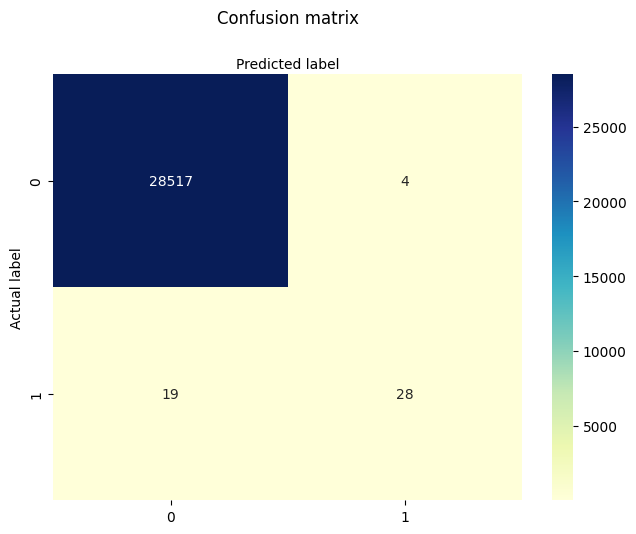

In [29]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

class_names = [0,1] # name  of classes 
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

---
## Serving

### Save The Model

In [30]:
#trying pickle
!mkdir model_artifacts

with open('model_artifacts/model.pkl','wb') as f:
    pickle.dump(model,f)

In [31]:
# Upload the model to GCS
bucket = storage.Client().bucket(BUCKET)
blob = bucket.blob(BLOB)
blob.upload_from_filename('model_artifacts/model.pkl')

In [32]:
# confirm model is in the right bucket
!gsutil ls {URI}/models/{TIMESTAMP}/model/

gs://demos-vertex-ai/03/03/models/20250121203058/model/model.pkl


In [33]:
expRun.log_params({'model.save': f'{URI}/models/{TIMESTAMP}/model'})

### Upload The Model

In [34]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model = modelmatch[0].resource_name

else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'experiment_name' : f'{EXPERIMENT_NAME}', 'run_name' : f'{RUN_NAME}'}        
    )

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/746038361521/locations/us-central1/models/model_03_03/operations/448397231402254336
Model created. Resource name: projects/746038361521/locations/us-central1/models/model_03_03@2
To use this Model in another session:
model = aiplatform.Model('projects/746038361521/locations/us-central1/models/model_03_03@2')


In [35]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03_03?project=demos-vertex-ai


### Vertex AI Experiment Update and Review

In [36]:
expRun.log_params({
    'model.uri': model.uri,
    'model.display_name': model.display_name,
    'model.name': model.name,
    'model.resource_name': model.resource_name,
    'model.version_id': model.version_id,
    'model.versioned_resource_name': model.versioned_resource_name
})

Complete the experiment run:

In [37]:
expRun.update_state(state = aiplatform.gapic.Execution.State.COMPLETE)

Retrieve the experiment:

In [38]:
exp = aiplatform.Experiment(experiment_name = EXPERIMENT_NAME)

In [39]:
exp.get_data_frame()

,experiment_name,run_name,run_type,state,param.model.resource_name,param.project_id,param.nclasses,param.model.versioned_resource_name,param.model.display_name,param.penalty,...,metric.training_accuracy,metric.validation_accuracy,metric.validation_recall,metric.training_recall,metric.validation_precision,metric.test_precision,metric.test_roc_auc,metric.test_recall,metric.training_precision,metric.test_accuracy
0,experiment-03-03-sklearn-classification-logist...,run-20250121203058,system.ExperimentRun,COMPLETE,projects/746038361521/locations/us-central1/mo...,demos-vertex-ai,2.0,projects/746038361521/locations/us-central1/mo...,03_03,l2,...,0.999219,0.999051,0.607143,0.62982,0.871795,0.875,0.797802,0.595745,0.878136,0.999195


### Review Experiment and Run in Console

In [40]:
print(f'Review The Experiment in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/experiments/{EXPERIMENT_NAME}?project={PROJECT_ID}')

Review The Experiment in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/experiments/experiment-03-03-sklearn-classification-logistic-regression?project=demos-vertex-ai


In [42]:
print(f'Review The Experiment Run in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/experiments/{EXPERIMENT_NAME}/runs/{EXPERIMENT_NAME}-{RUN_NAME}?project={PROJECT_ID}')

Review The Experiment Run in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/experiments/experiment-03-03-sklearn-classification-logistic-regression/runs/experiment-03-03-sklearn-classification-logistic-regression-run-20250121203058?project=demos-vertex-ai


### Compare This Run Using Experiments

Get a list of all experiments in this project:

In [43]:
experiments = aiplatform.Experiment.list()

Remove experiments not in the SERIES:

In [44]:
experiments = [e for e in experiments if e.name.split('-')[0:2] == ['experiment', SERIES]]

Combine the runs from all experiments in SERIES into a single dataframe:

In [45]:
results = []
for experiment in experiments:
        results.append(experiment.get_data_frame())
        print(experiment.name)
results = pd.concat(results)

experiment-03-03-sklearn-classification-logistic-regression


Create ranks for models within experiment and across the entire SERIES:

In [46]:
def ranker(metric = 'metric.test_roc_auc'):
    ranks = results[['experiment_name', 'run_name', 'param.model.display_name', 'param.model.version_id', metric]].copy().reset_index(drop = True)
    ranks['series_rank'] = ranks[metric].rank(method = 'dense', ascending = False)
    ranks['experiment_rank'] = ranks.groupby('experiment_name')[metric].rank(method = 'dense', ascending = False)
    return ranks.sort_values(by = ['experiment_name', 'run_name'])
    
ranks = ranker('metric.test_roc_auc')
ranks

,experiment_name,run_name,param.model.display_name,param.model.version_id,metric.test_roc_auc,series_rank,experiment_rank
0,experiment-03-03-sklearn-classification-logist...,run-20250121203058,03_03,2,0.797802,1.0,1.0


In [47]:
current_rank = ranks.loc[(ranks['param.model.display_name'] == model.display_name) & (ranks['param.model.version_id'] == model.version_id)]
current_rank

,experiment_name,run_name,param.model.display_name,param.model.version_id,metric.test_roc_auc,series_rank,experiment_rank
0,experiment-03-03-sklearn-classification-logist...,run-20250121203058,03_03,2,0.797802,1.0,1.0


In [48]:
print(f"The current model is ranked {current_rank['experiment_rank'].iloc[0]} within this experiment and {current_rank['series_rank'].iloc[0]} across this series.")

The current model is ranked 1.0 within this experiment and 1.0 across this series.


### Create An Endpoint

In [49]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")
    
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Creating Endpoint
Create Endpoint backing LRO: projects/746038361521/locations/us-central1/endpoints/7517731534523072512/operations/7098525031168212992
Endpoint created. Resource name: projects/746038361521/locations/us-central1/endpoints/7517731534523072512
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/746038361521/locations/us-central1/endpoints/7517731534523072512')
Endpoint Created: projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/7517731534523072512?project=demos-vertex-ai


In [50]:
endpoint.display_name

'03'

In [51]:
endpoint.traffic_split

{}

In [52]:
deployed_models = endpoint.list_models()
deployed_models

[]

### Should This Model Be Deployed?
Is it better than the model already deployed on the endpoint?

In [53]:
deploy = False
if deployed_models:
    for deployed_model in deployed_models:
        deployed_rank = ranks.loc[(ranks['param.model.display_name'] == deployed_model.display_name) & (ranks['param.model.version_id'] == deployed_model.model_version_id)]['series_rank'].iloc[0]
        model_rank = current_rank['series_rank'].iloc[0]
        if deployed_model.display_name == model.display_name and deployed_model.model_version_id == model.version_id:
            print(f'The current model/version is already deployed.')
            break
        elif model_rank <= deployed_rank:
            deploy = True
            print(f'The current model is ranked better ({model_rank}) than a currently deployed model ({deployed_rank}).')
            break
    if deploy == False: print(f'The current model is ranked worse ({model_rank}) than a currently deployed model ({deployed_rank})')
else: 
    deploy = True
    print('No models currently deployed.')

No models currently deployed.


### Deploy Model To Endpoint

In [54]:
if deploy:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: print(f'Not deploying - current model is worse ({model_rank}) than the currently deployed model ({deployed_rank})')

Deploying model with 100% of traffic...
Deploying Model projects/746038361521/locations/us-central1/models/model_03_03 to Endpoint : projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Deploy Endpoint model backing LRO: projects/746038361521/locations/us-central1/endpoints/7517731534523072512/operations/1333917508133978112
Endpoint model deployed. Resource name: projects/746038361521/locations/us-central1/endpoints/7517731534523072512


### Remove Deployed Models without Traffic

In [55]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model 03_03 with version 2 has traffic = 100


In [56]:
endpoint.traffic_split

{'7843569606391234560': 100}

In [57]:
endpoint.list_models()

[id: "7843569606391234560"
 model: "projects/746038361521/locations/us-central1/models/model_03_03"
 display_name: "03_03"
 create_time {
   seconds: 1737491746
   nanos: 549756000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-4"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 model_version_id: "2"]

---
## Prediction

### Prepare a record for prediction: instance list

In [58]:
instances = [X_test.to_dict(orient='split')['data'][0]]

In [59]:
instances[0]

[430,
 -1.8602576921529799,
 -0.629858920058775,
 0.9665704477622901,
 0.844632076311716,
 0.7599826624018221,
 -1.4811729034822199,
 -0.509681452204136,
 0.540722084608081,
 -0.733623387939623,
 -0.371621504466433,
 0.859741162489679,
 0.37260884000575,
 -1.24018476590577,
 0.9983913288801859,
 -0.34638712534557,
 -0.391678582539051,
 0.348289432299279,
 0.28212476552471993,
 1.1658931653446398,
 0.32044962522685,
 0.268027795908505,
 0.125515236056546,
 -0.22502853542401702,
 0.586664442562558,
 -0.0315980821137267,
 0.570168024306224,
 -0.0430074855159307,
 -0.22373947952524498,
 0.0]

### Get Predictions: Python Client

In [60]:
prediction = endpoint.predict(instances=instances)
prediction

Prediction(predictions=[0.0], deployed_model_id='7843569606391234560', metadata=None, model_version_id='2', model_resource_name='projects/746038361521/locations/us-central1/models/model_03_03', explanations=None)

In [61]:
prediction.predictions[0]

0.0

In [62]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST

In [63]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": instances}))

In [64]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    0
  ],
  "deployedModelId": "7843569606391234560",
  "model": "projects/746038361521/locations/us-central1/models/model_03_03",
  "modelDisplayName": "03_03",
  "modelVersionId": "2"
}


### Get Predictions: gcloud (CLI)

In [67]:
# !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

---
## Remove Resources
see notebook "99 - Cleanup"

### Delete Endpoint

In [68]:
## DELETE DEPLOYED MODEL AND ENDPOINT 
endpoint.delete(force=True)

Undeploying Endpoint model: projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Undeploy Endpoint model backing LRO: projects/746038361521/locations/us-central1/endpoints/7517731534523072512/operations/8479441266910691328
Endpoint model undeployed. Resource name: projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Deleting Endpoint : projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Endpoint deleted. . Resource name: projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Deleting Endpoint resource: projects/746038361521/locations/us-central1/endpoints/7517731534523072512
Delete Endpoint backing LRO: projects/746038361521/locations/us-central1/operations/6752310809814106112
Endpoint resource projects/746038361521/locations/us-central1/endpoints/7517731534523072512 deleted.
